In [1]:
from network_evaluation_tools import gene_conversion_tools as gct
from network_evaluation_tools import data_import_tools as dit
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
wd = '/cellar/users/snwright/Data/Network_Analysis/'

# Version 2
## Load HumanNet Raw Data
**Source:  https://www.inetbio.org/humannet/networks/HumanNet-FN.tsv & https://www.inetbio.org/humannet/networks/HumanNet-XC.tsv**  

Downloaded: November 16, 2021  
Last updated: 2021, published Jan 2022   
  
**Note**: There are multiple networks available, we have chosen to use the composite Functional Network(FN) which contains data from co-expression (CX), pathway databases (DB), domain profile associations (DP), genetic interactions (GI), gene neighborhood (GN), phylogenetic profile associations (PG) and protein-protein interaction networks (PI). Data is also extracted from the XC network which contains all of FN with additional co-citation links

<u>HumanNet Citations</u>:  
**V1**: Insuk Lee, U. Martin Blom, Peggy I. Wang, Jung Eun Shin, and Edward M. Marcotte
Genome Research 21(7):1109-21 (2011)  
**V2**: Hwang S, Kim CY, Yang S, Kim E, Hart T, Marcotte EM, Lee I. HumanNet v2: human gene networks for disease research. Nucleic Acids Research 2019 Jan 8;47(D1):D573–D580  
**V3**:Kim, Chan Yeong, Seungbyn Baek, Junha Cha, Sunmo Yang, Eiru Kim, Edward M. Marcotte, Traver Hart, and Insuk Lee. 2022. “HumanNet v3: An Improved Database of Human Gene Networks for Disease Research.” Nucleic Acids Research 50 (D1): D632–39.  


In [3]:
input_raw_XC = pd.read_csv(wd+'Network_Data_Raw/HumanNet_v3/HumanNet-XC.tsv',sep='\t',header=None)
input_raw_XC.columns = ["Gene 1", "Gene 2", "IntNet"]
input_raw_FN = pd.read_csv(wd+'Network_Data_Raw/HumanNet_v3/HumanNet-FN.tsv',sep='\t',header=None)
input_raw_FN.columns = ["Gene 1", "Gene 2", "IntNet"]

In [4]:
input_raw_XC.head()

,Gene 1,Gene 2,IntNet
0,7046,7048,6.044828
1,5211,5213,5.942313
2,10641,9681,5.899878
3,5213,5214,5.898546
4,5211,5214,5.898122


In [5]:
# Extract gene list
genes_XC = set(input_raw_XC['Gene 1']).union(set(input_raw_XC['Gene 2']))

In [6]:
# Extract gene list
genes_FN = set(input_raw_FN['Gene 1']).union(set(input_raw_FN['Gene 2']))


In [7]:
genes_v2 = list(genes_XC.union(genes_FN))
genes_v2 = [str(gene) for gene in genes_v2]

##  Convert genes from Entrez ID to HUGO Symbol

In [8]:
query_string_v2, valid_genes_v2, invalid_genes_v2 = gct.query_constructor(genes_v2)

18595 Valid Query Genes
0 Invalid Query Genes


In [9]:
# Set scopes (gene naming systems to search)
scopes = "entrezgene, retired"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list_v2 = gct.query_batch(query_string_v2, scopes=scopes, fields=fields)

100%|██████████| 19/19 [00:17<00:00,  1.06it/s]

18595 Matched query results
Batch query complete: 18.0 seconds


In [10]:
match_list_v2 = pd.DataFrame.from_dict(match_list_v2)

In [11]:
match_table_trim_v2, query_to_symbol_v2, query_to_entrez_v2 = gct.construct_query_map_table(match_list_v2, valid_genes_v2)

Number of genes with multiple matches: 0
Number of unmatched genes: 0
Number of fully matched genes: 18595
Number of partially matched genes: 0


## Construct Converted Network

In [12]:
# Convert weighted edge list
edgelist_symbol_XC = gct.convert_edgelist(input_raw_XC, query_to_symbol_v2)

CPU times: user 1.71 s, sys: 64.2 ms, total: 1.78 s
Wall time: 1.79 s


In [13]:
# Convert weighted edge list
edgelist_symbol_FN = gct.convert_edgelist(input_raw_FN, query_to_symbol_v2)

CPU times: user 1.49 s, sys: 37.9 ms, total: 1.52 s
Wall time: 1.53 s


In [17]:
# Filter converted edge list
edgelist_filt_XC = gct.filter_converted_edgelist(edgelist_symbol_XC, weight_col='IntNet')

1125494 input edges
1 self-edges removed
0 edges with un-mapped genes removed
1 duplicate edges removed
Edge list filtered: 0.7 seconds
1125493 Edges remaining


In [19]:
# Filter converted edge list
edgelist_filt_FN = gct.filter_converted_edgelist(edgelist_symbol_FN, weight_col='IntNet')

977495 input edges
1 self-edges removed
0 edges with un-mapped genes removed
1 duplicate edges removed
Edge list filtered: 0.61 seconds
977494 Edges remaining


In [20]:
# Write network to file
gct.write_edgelist(edgelist_filt_XC, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC_Symbol_v3.sif', binary=False)

Edge list saved: 2.09 seconds


In [21]:
# Write network to file
gct.write_edgelist(edgelist_filt_FN, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN_Symbol_v3.sif', binary=False)

Edge list saved: 1.84 seconds


In [22]:
# Create filtered network
edgelist_XC_90 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC_Symbol_v3.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-XC90_Symbol_v3.sif')

90.0% score: 3.4110431775494323
112550 / 1125493 edges retained


In [23]:
# Create filtered network
edgelist_FN_90 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN_Symbol_v3.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet-FN90_Symbol_v3.sif')

90.0% score: 3.2593202710699
97736 / 977494 edges retained


# Version 1
## Load HumanNet Raw Data
**Source: http://www.functionalnet.org/humannet/HumanNet.v1.benchmark.txt**  
Downloaded: August 12, 2016  
No latest version date posted (last updated likely around 2011).  
Citation: Insuk Lee, U. Martin Blom, Peggy I. Wang, Jung Eun Shin, and Edward M. Marcotte
Genome Research 21(7):1109-21 (2011)

In [24]:
input_raw= pd.read_csv(wd+'Network_Data_Raw/HumanNet.v1.join.txt',sep='\t',header=None)

In [25]:
f = open(wd+'Network_Data_Raw/HumanNet.v1.evidence_code.txt')
HumanNet_headers = ['Gene 1', 'Gene 2']+[name.split(' = ')[0] for name in f.read().splitlines()[1:-1]]
input_raw.columns = HumanNet_headers

In [26]:
input_raw.head()

,Gene 1,Gene 2,CE-CC,CE-CX,CE-GT,CE-LC,CE-YH,DM-PI,HS-CC,HS-CX,...,HS-PG,HS-YH,SC-CC,SC-CX,SC-GT,SC-LC,SC-MS,SC-TS,SC-YH,IntNet
0,1743,4967,NaN,0.490660,NaN,NaN,NaN,NaN,3.645185,NaN,...,NaN,NaN,2.338262,NaN,NaN,3.000132,3.243989,NaN,NaN,4.256856
1,4171,4172,NaN,2.304166,NaN,NaN,NaN,2.122390,NaN,2.016765,...,NaN,NaN,3.217315,1.729727,2.370826,3.141053,1.762031,2.380625,NaN,4.254664
2,2237,5111,NaN,NaN,NaN,NaN,NaN,NaN,2.942468,1.933299,...,NaN,NaN,2.712615,3.652874,NaN,3.066321,2.870491,NaN,NaN,4.242339
3,1974,1981,NaN,NaN,NaN,NaN,NaN,1.498094,NaN,NaN,...,NaN,NaN,NaN,NaN,2.329113,1.545048,3.263899,NaN,NaN,4.239118
4,506,509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.439170,...,NaN,NaN,2.797204,NaN,NaN,2.973234,0.126722,2.534857,NaN,4.235136


In [28]:
# Extract gene list
genes = list(set(input_raw['Gene 1']).union(set(input_raw['Gene 2'])))
genes = [str(gene) for gene in genes]

In [29]:
edgelist = input_raw.loc[:, ("Gene 1", "Gene 2", "IntNet")]

##  Convert genes from Entrez ID to HUGO Symbol

In [30]:
query_string, valid_genes, invalid_genes = gct.query_constructor(genes)

16243 Valid Query Genes
0 Invalid Query Genes


In [31]:
# Set scopes (gene naming systems to search)
scopes = "entrezgene, retired"

# Set fields (systems from which to return gene names from)
fields = "symbol, entrezgene"

# Query MyGene.Info
match_list = gct.query_batch(query_string, scopes=scopes, fields=fields)
print(len(match_list), 'Matched query results')

100%|██████████| 17/17 [00:14<00:00,  1.13it/s]

16243 Matched query results
Batch query complete: 14.98 seconds
16243 Matched query results


In [32]:
match_list = pd.DataFrame.from_dict(match_list)

In [35]:
match_table_trim, query_to_symbol, query_to_entrez = gct.construct_query_map_table(match_list, valid_genes)

Number of genes with multiple matches: 0
Number of unmatched genes: 14
Number of fully matched genes: 16229
Number of partially matched genes: 14


## Construct Converted Network

In [36]:
%%time
# Convert weighted edge list
edgelist_symbol = gct.convert_edgelist(edgelist, query_to_symbol)

CPU times: user 721 ms, sys: 12.5 ms, total: 733 ms
Wall time: 734 ms


In [37]:
# Filter converted edge list
edgelist_filt = gct.filter_converted_edgelist(edgelist_symbol, weight_col='IntNet')

476399 input edges
8 self-edges removed
315 edges with un-mapped genes removed
531 duplicate edges removed
Edge list filtered: 0.28 seconds
475868 Edges remaining


In [38]:
# Write network to file
gct.write_edgelist(edgelist_filt, wd+'Processed_Data/Network_SIFs_Symbol/HumanNet_Symbol_v1.sif', binary=False)

Edge list saved: 0.92 seconds


In [39]:
# Create filtered network
edgelist_90 = dit.filter_weighted_network_sif(wd+'Processed_Data/Network_SIFs_Symbol/HumanNet_Symbol_v1.sif', nodeA_col=0, nodeB_col=1, score_col=2, 
                                                      q=0.9, delimiter='\t', verbose=True, save_path=wd+'Processed_Data/Network_SIFs_Symbol/HumanNet90_Symbol_v1.sif')

90.0% score: 2.171025927214523
47555 / 475868 edges retained


# Changes

Changes to data structure:
* Initial version supplied edges with a matrix of evidence codes and score corresponding to each code (or NaN), plus a summary score
* New release provides independent networks for each of the classes of evidence, as well as combined networks of all functionally supported edges, and all functionally supported edges + co citation supported edges. The combined network does not come with annotations as to the source of the edge, but this information can be gleaned from the individual component networks. It appears the bulk of the data is supported by Human data.

No human filtering done


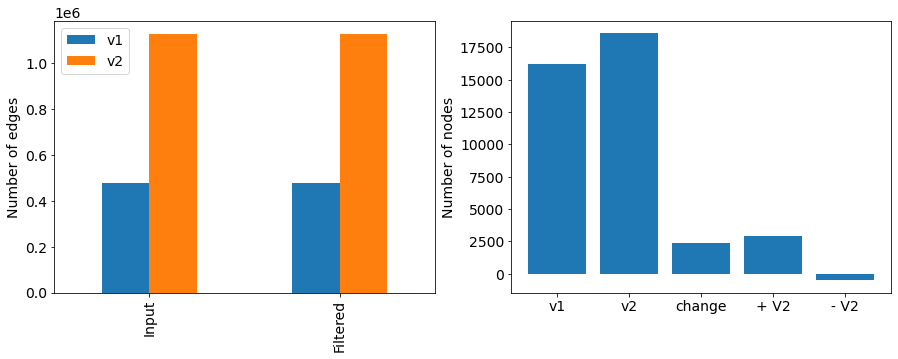

In [41]:
# Compare original to XC
dit.plot_changes_to_dataset(input_raw, input_raw_XC, edgelist_filt, edgelist_filt_XC)

No human filtering done


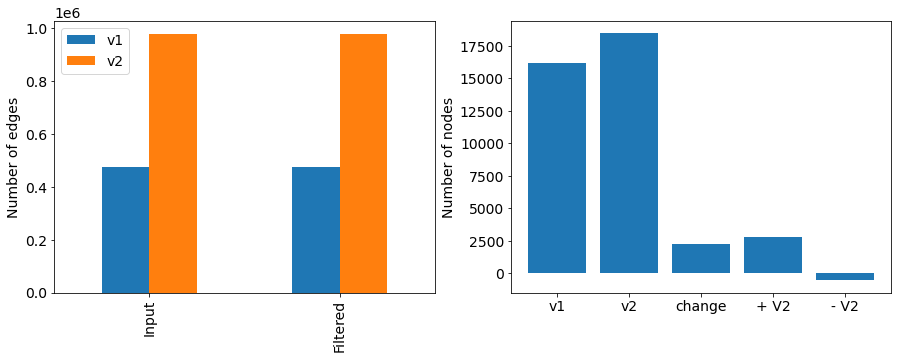

In [42]:
# Compare original to FN
dit.plot_changes_to_dataset(input_raw, input_raw_FN, edgelist_filt, edgelist_filt_FN)

No human filtering done


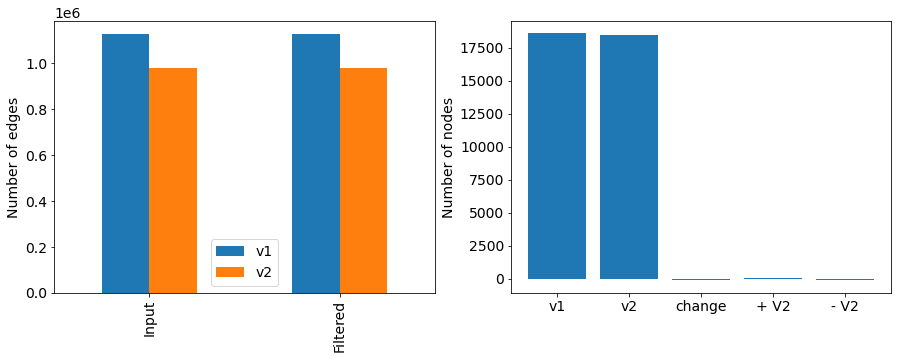

In [44]:
# Compare original to XC to FN
dit.plot_changes_to_dataset(input_raw_XC, input_raw_FN, edgelist_filt_XC, edgelist_filt_FN)